In [1]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as cm
import ProbabilisticParcellation.functional_profiles as fp
from Functional_Fusion.dataset import *
import matplotlib.pyplot as plt
import string
import PcmPy as pcm
from copy import deepcopy
import torch as pt



base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/Users/callithrix/Documents/Projects/Functional_Fusion/'
if not Path(base_dir).exists():
    raise (NameError('Could not find base_dir'))
    

## Load profile data and model

In [2]:
atlas = 'MNISymC2'

# load model
mname = f'/Models_03/sym_MdPoNiIbWmDeSo_space-{atlas}_K-32_meth-mixed'
fileparts = mname.split('/')
split_mn = fileparts[-1].split('_')
info, model = ut.load_batch_best(mname)


# load labels and cmap
lut_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'
_, cmap, labels = nt.read_lut(lut_dir +
                              f'{fileparts[-1]}.lut')
labels=labels[1:]

# load profile
profile = pd.read_csv(
    f'{ut.model_dir}/Atlases/{fileparts[-1]}_profile.tsv', sep="\t"
)


In [ ]:
# Reduce profile to only MDTB Tasks
profile = profile[profile.dataset == 'MDTB']

# Make profile into matrix
profile_mat = profile[labels].to_numpy()

# Normalize profile
profile_scaled = (profile_mat - np.mean(profile_mat, axis=0))


([<matplotlib.axis.YTick at 0x7f7a62082790>,
 [Text(0, 0, 'NoGo'),
  Text(0, 5, 'UnpleasantScenes'),
  Text(0, 10, 'SadFaces'),
  Text(0, 15, 'FingerSeq'),
  Text(0, 20, 'SpatialNavigation'),
  Text(0, 25, 'VisualSearchSmall'),
  Text(0, 30, 'Prediction'),
  Text(0, 35, 'SpatialNavigation'),
  Text(0, 40, 'RomanceMovie'),
  Text(0, 45, 'MentalRotMed'),
  Text(0, 50, 'BodyMotionScram'),
  Text(0, 55, 'VisualSearchMed'),
  Text(0, 60, 'rest')])

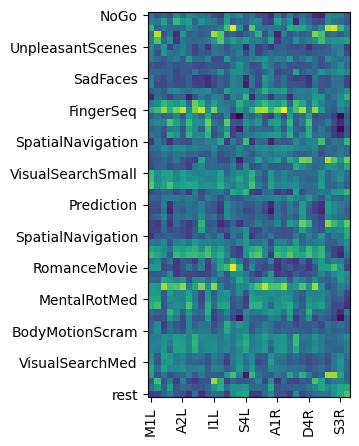

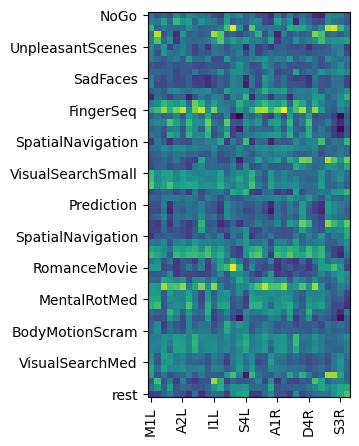

In [ ]:
# Show profile

figsize = (5, 5)
# figsize = (40, 20)
plt.figure(figsize=figsize)
plt.imshow(profile_mat)
plt.xticks(np.arange(len(labels))[::5], labels[::5], rotation=90)
plt.yticks(np.arange(len(profile))[::5], profile.condition[::5])


# Show scaled profile
plt.figure(figsize=figsize)
plt.imshow(profile_scaled)
plt.xticks(np.arange(len(labels))[::5], labels[::5], rotation=90)
plt.yticks(np.arange(len(profile))[::5], profile.condition[::5])


### Load cognitive feature tags

In [ ]:
# Load cognitive features
tags = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/tags/tags.csv', sep="\t"
)
tags = tags[tags.dataset == 'MDTB']
# Remove all tags after right_toe_response_execution
last_mdtb_tag = tags.columns.tolist().index('right_toe_response_execution')
tags = tags.iloc[:, :last_mdtb_tag]
tags_mat = tags[tags.columns[3:]].to_numpy()

# Reduce tags to only MDTB Tasks


In [ ]:
# Subtract mean from each column and divide by standard deviation of each column
tags_mat = (tags_mat - np.mean(tags_mat, axis=0)) / np.std(tags_mat, axis=0)

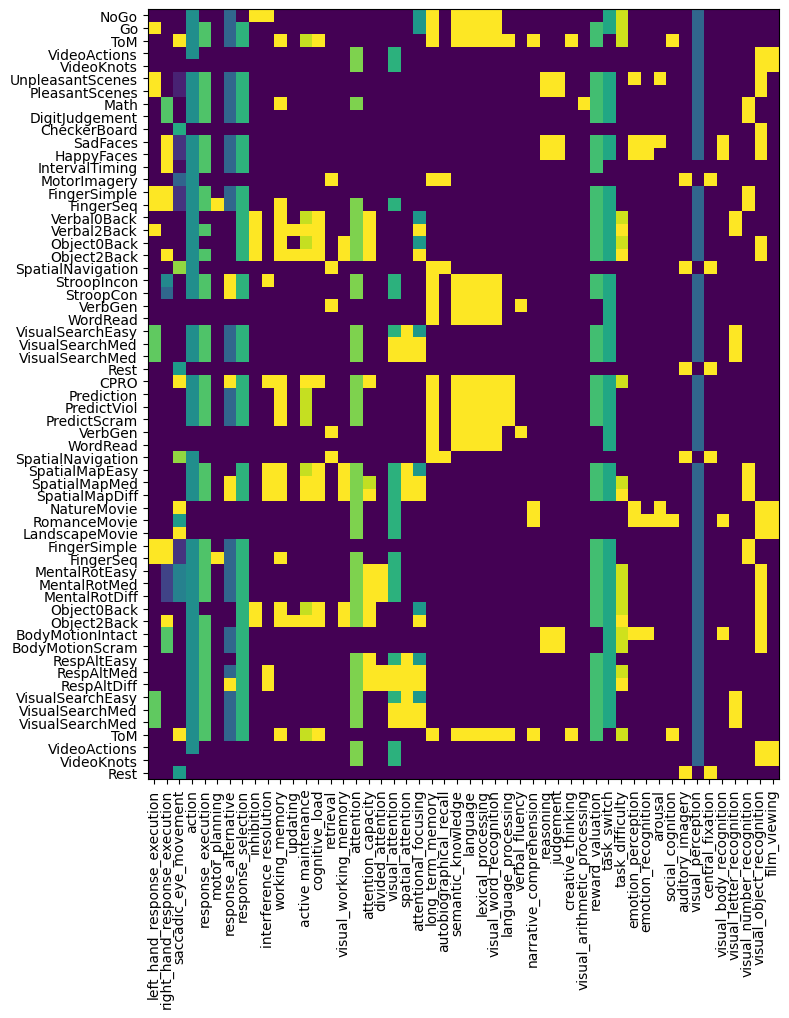

In [ ]:
# Show features
plt.figure(figsize=(10, 10))
plt.imshow(tags_mat, vmin=0, vmax=1)
plt.xticks(np.arange(len(tags.columns[3:])), tags.columns[3:], rotation=90)
plt.yticks(np.arange(len(profile[profile.dataset == 'MDTB'])),
           tags[tags.dataset == 'MDTB'].condition)
# Make figure wider
plt.gcf().set_size_inches(100, 10)

In [ ]:
from ridge_reg import ridgeFit
R2, features = ridgeFit(profile_mat, tags_mat, fit_intercept=False, voxel_wise=False, alpha=1.0)
# Make dataframe with B values, profile.dataset, profile.condition, tags.columns[3:]
Features = pd.DataFrame(features.T, columns=tags.columns[3:], index=labels)



ModuleNotFoundError: No module named 'ridge_reg'

([<matplotlib.axis.YTick at 0x7fa5898d8eb0>,
 [Text(0, 0, 'left_hand_response_execution'),
  Text(0, 1, 'right_hand_response_execution'),
  Text(0, 2, 'saccadic_eye_movement'),
  Text(0, 3, 'action'),
  Text(0, 4, 'response_execution'),
  Text(0, 5, 'motor_planning'),
  Text(0, 6, 'response_alternative'),
  Text(0, 7, 'response_selection'),
  Text(0, 8, 'inhibition'),
  Text(0, 9, 'interference resolution'),
  Text(0, 10, 'working_memory'),
  Text(0, 11, 'updating'),
  Text(0, 12, 'active maintenance'),
  Text(0, 13, 'cognitive_load'),
  Text(0, 14, 'retrieval'),
  Text(0, 15, 'visual_working_memory'),
  Text(0, 16, 'attention'),
  Text(0, 17, 'attention_capacity'),
  Text(0, 18, 'divided_attention'),
  Text(0, 19, 'visual_attention'),
  Text(0, 20, 'spatial_attention'),
  Text(0, 21, 'attentional_focusing'),
  Text(0, 22, 'long_term_memory'),
  Text(0, 23, 'autobiographical_recall'),
  Text(0, 24, 'semantic_knowledge'),
  Text(0, 25, 'language'),
  Text(0, 26, 'lexical_processing'),
 

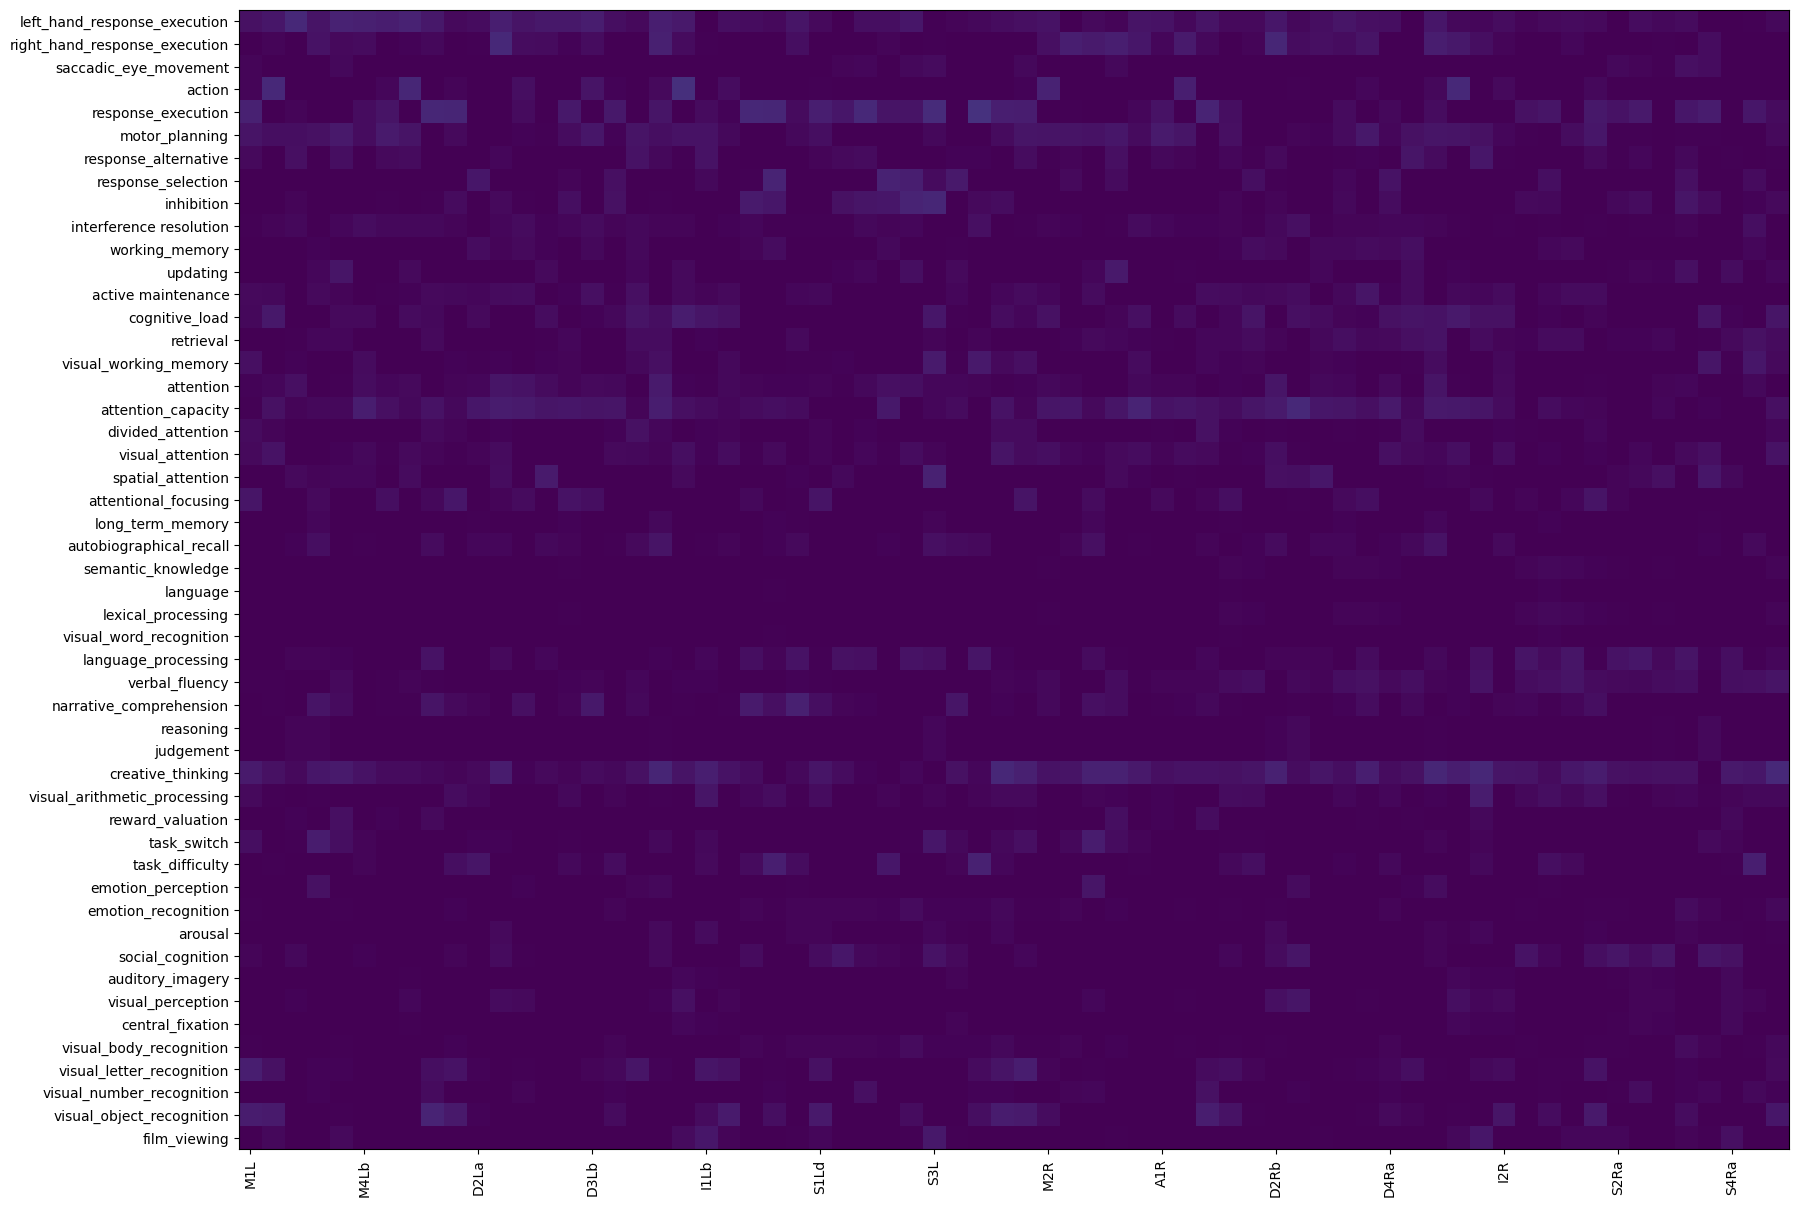

In [ ]:
# Plot
plt.figure(figsize=(20, 20))
plt.imshow(features, vmin=0, vmax=1)
plt.xticks(np.arange(len(labels))[::5], labels[::5], rotation=90)
plt.yticks(np.arange(len(tags.columns[3:])), tags.columns[3:])


In [ ]:
def print_tags(profile, df, labels, region=None, n=5):

    for i, r in enumerate(labels):
        if (region is None) | (r == region):
            print(f'\nregion {r}')

            # Sort conditions by score
            scores = profile[:, i]
            zipped = zip(scores, df.columns[3:])
            zipped = sorted(zipped, key=lambda x: x[0], reverse=True)
            scores, conds = zip(*zipped[:n])

            [print(f'{cond}: {score}')
             for score, cond in zip(scores, conds)]


In [ ]:
for region in ['M1L', 'S1Ra', 'S2Ra', 'S2La', 'M3Ra', 'M3Ra', 'M3La', 'M4Ra', 'S4Ra']:
    print_tags(features, Features, labels, region=region, n=10)



region M1L
response_selection: 0.09164895963276533
film_viewing: 0.0844468128445289
task_switch: 0.07310957076027674
semantic_knowledge: 0.05841545896479658
inhibition: 0.05159749170231506
action: 0.04556651157472005
divided_attention: 0.03943210401613381
emotion_recognition: 0.03590734097242737
attentional_focusing: 0.029947844430186298
visual_working_memory: 0.027215572693121748

region S1Ra
reasoning: 0.05435774939971181
task_switch: 0.05431728707996249
central_fixation: 0.0486089030699386
response_selection: 0.044918335311846476
judgement: 0.03445451959282427
updating: 0.0255784469302552
task_difficulty: 0.02016534228286969
creative_thinking: 0.017038324859821215
semantic_knowledge: 0.013584334756208957
visual_word_recognition: 0.012562259045896355

region S2Ra
central_fixation: 0.05473863717967344
response_selection: 0.04723147162789858
reasoning: 0.04715262580014438
task_switch: 0.04658294158534917
judgement: 0.02718353218948507
updating: 0.021079748083222157
motor_planning: 0.0

In [7]:
for region in ['M1L', 'S1Ra', 'S2Ra', 'S2La', 'M3Ra', 'M3Ra', 'M3La', 'M4Ra', 'S4Ra']:
    print_tags(profile_mat, profile, labels, region=region, n=10)


NameError: name 'print_tags' is not defined

In [14]:

dataset = None

for region in ['I1aL',
               'I1bL',
               'I2L']:
    print_highest(profile_norm, profile, labels,
                  region=region, dataset=dataset)
    # print_highest(profile_mat, profile, labels, region=region)
    # print_tags(features, tags, labels, region=region)
    print_tags(features_norm, tags, labels, region=region, n=10)



region I1aL
MDTB VideoAct: 0.3630583435377129
MDTB VideoAct: 0.36243861951801176
Somatotopic hand-left: 0.2943481994712636
Nishimoto PropLogic: 0.28238191304507976
Nishimoto DetectDifference: 0.280102487576955

region I1aL
left_hand_response_execution: 5.744095035977968
film_viewing: 2.7676849207684215
retrieve: 1.8680818075765537
visual_sentence_comprehension: 1.8602173559580837
response_execution: 1.8264020335788431
visual_attention: 1.4998199895388875
feature_comparison: 1.3145394292239676
visual_buffer: 1.2503505660601282
visual_string_recognition: 1.2381389602962969
easy: 1.1871554471444157

region I1bL
MDTB VideoKnots: 0.31586179221670563
IBC we-all-reference: 0.304431011248325
Nishimoto DetectTargetPic: 0.27382728923533395
IBC intersection: 0.25592766544623985
Nishimoto CalcHard: 0.25437935058848105

region I1bL
response_alternative: 2.1205795802438328
spatial_attention: 1.903013837709
visual_object_recognition: 1.8367827514063109
right_hand_response_execution: 1.66461287591388